# Go Winner Prediction
The meaning of this project follows from the name. The user sends us an image of the endgame position of the Go game, and we tell him who is the loser and winner.


<img src="https://tenminutestogo.files.wordpress.com/2020/07/go-game-asian-illustration.jpg">

## Resources for training model
GPU was provided with Kaggle free quota

In [1]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free --format=csv

name, memory.total [MiB], memory.free [MiB]
Tesla P100-PCIE-16GB, 16280 MiB, 16280 MiB


## Libraries

In [2]:
from collections import Counter 
from prettytable import PrettyTable
from tqdm import tqdm
from PIL import Image
from torch import nn
from torchvision import transforms, datasets, utils

import torch
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import cv2

import os
import random

## Downloading datasets

In [3]:
!pip install gdown > /dev/null
!gdown --id 1X3g3NDOBN5zF-Egn6Jm__DeXepUDvCpi # dataset 
!gdown --id 11PzGNPWmjSgjrKudVJ8qXY3MpqhJPOms # go apps backgrounds
!gdown --id 1E_tlhY0ynGumGTrWTbbW5ObWn-Pq3-nH # epoch-metric info

Downloading...
From: https://drive.google.com/uc?id=1X3g3NDOBN5zF-Egn6Jm__DeXepUDvCpi
To: /kaggle/working/extended-dataset.zip
100%|███████████████████████████████████████| 4.67G/4.67G [00:40<00:00, 117MB/s]
Downloading...
From: https://drive.google.com/uc?id=11PzGNPWmjSgjrKudVJ8qXY3MpqhJPOms
To: /kaggle/working/go-apps-backgrounds.zip
100%|███████████████████████████████████████| 61.4M/61.4M [00:00<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=1E_tlhY0ynGumGTrWTbbW5ObWn-Pq3-nH
To: /kaggle/working/epoch-metrics.csv
100%|██████████████████████████████████████| 1.15k/1.15k [00:00<00:00, 2.08MB/s]


In [4]:
!unzip extended-dataset.zip > /dev/null
!unzip go-apps-backgrounds.zip > /dev/null

## Set some basic parameters and constants

In [5]:
DATASET_DIR = "dataset"
BACKGROUNDS_DIR = "./"
TRAIN_PERCENT = 0.8
VALID_PERCENT = 0.15
TEST_PERCENT = 0.05

SEED = 42
BATCH_SIZE = 8
TEST_BATCH_SIZE = 32
EPOCHS = 45

np.random.seed(SEED)
torch.manual_seed(SEED)

plt.rcParams["figure.figsize"] = [15, 8]
plt.rcParams["font.size"] = 20

## Custom augmentation class

In [6]:
class AppBackgroundWithShift:
    def __init__(self, p: float, path_to_backgrounds: str, output_size:tuple, proba_angle_reverse: int = 0.3):
        self.p = p
        self.path_to_backgrounds = path_to_backgrounds
        self.output_size = output_size
        self.proba_angle_reverse = proba_angle_reverse
        
    def __call__(self, sample):
        PROBA_augmentation = random.random()
        
        if self.p < PROBA_augmentation <= 1:
            return transforms.Resize(self.output_size)(sample)
        
        w, h = self.output_size
        
        image_ratio = random.uniform(0.55, 1)
    
        image_w, image_h = int(image_ratio * w), int(image_ratio * h)
        diff_border_w, diff_border_h = w - image_w, h - image_h
        
        n_backgrounds = len(os.listdir(self.path_to_backgrounds))
        i_random_background = random.randint(0, len(os.listdir(self.path_to_backgrounds))-1)
        
        PROBA_reverse = random.random()
        if 0 <= PROBA_reverse <= self.proba_angle_reverse:
            self.affine_angle = 180
        
        lower_w_diff,higher_w_diff = diff_border_h//2, h - image_h - diff_border_h//2
        lower_h_diff, higher_h_diff = diff_border_w//2, w - image_w - diff_border_w//2
        RANDOM_AFFINE_TRANSLATE_X = random.randint(-min(lower_w_diff, higher_w_diff), min(lower_w_diff, higher_w_diff))
        RANDOM_AFFINE_TRANSLATE_Y = random.randint(-min(lower_h_diff, higher_h_diff), min(lower_h_diff, higher_h_diff))
        
        background_image = Image.open(os.path.join(
                                                    self.path_to_backgrounds,
                                                   os.listdir(self.path_to_backgrounds)[i_random_background]))
                                      
        background_image = np.array(transforms.Resize(self.output_size)(background_image))
        background = random.randint(0, n_backgrounds - 1)

        image = transforms.Resize((image_w, image_h))(sample)
        
        image = cv2.copyMakeBorder(np.array(image), diff_border_w//2, w - image_w - diff_border_w//2, 
                                   diff_border_h//2, h - image_h - diff_border_h//2,cv2.BORDER_CONSTANT, value=0)
        
        t_x, t_y = RANDOM_AFFINE_TRANSLATE_X, RANDOM_AFFINE_TRANSLATE_Y
        image = transforms.functional.affine(Image.fromarray(image), 0, (t_x, t_y), 1, 0)
        background_image[diff_border_w//2 + t_y: image_w + diff_border_w//2 + t_y, 
                         diff_border_h//2 + t_x: image_h + diff_border_w//2 + t_x] = 0
        return Image.fromarray(cv2.add(np.array(image), background_image))

In [7]:
 def data_transforms(proba_custom_augmentation: float, output_size: tuple, backgrounds_path: str, include_grayscale: bool=False):
    transforms_list = []
    transforms_list.append(AppBackgroundWithShift(p = proba_custom_augmentation,
            path_to_backgrounds = backgrounds_path,
            output_size = output_size))
    if include_grayscale:
        transforms_list.append(transforms.Grayscale(num_output_channels=3))
    transforms_list.append(transforms.ToTensor())
        
    return transforms.Compose(transforms_list)

## Split dataset into train, validation and test sets


In [30]:
dataset = datasets.ImageFolder(root=DATASET_DIR,
                                           transform=data_transforms(0.7, (256, 256), os.path.join(BACKGROUNDS_DIR, "images"), True))
DATASET_LENGTH = len(dataset)
TRAIN_LENGTH = int(DATASET_LENGTH * TRAIN_PERCENT)
VALID_LENGTH = int(DATASET_LENGTH * VALID_PERCENT)
TEST_LENGTH = DATASET_LENGTH - TRAIN_LENGTH - VALID_LENGTH
train_dataset, valid_dataset, test_dataset= torch.utils.data.random_split(dataset, 
                                        [TRAIN_LENGTH, VALID_LENGTH, TEST_LENGTH], 
                                        generator=torch.Generator().manual_seed(SEED))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=TEST_BATCH_SIZE, shuffle=True)

## Our dataset is balanced for 2 classes

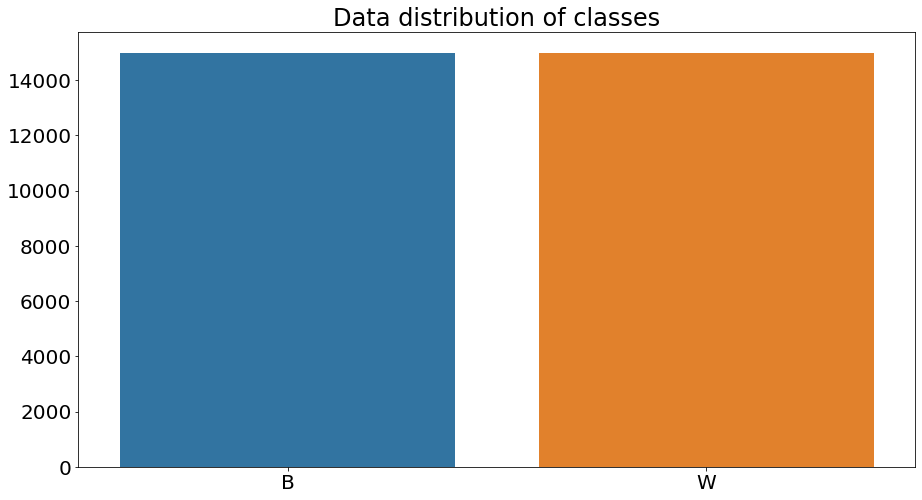

In [9]:
sns.barplot(data=pd.DataFrame(data = np.array([[*Counter(dataset.targets).values()]]), 
                                      columns=dataset.classes))
plt.title("Data distribution of classes");

In [10]:
datasets_length_table = PrettyTable()
datasets_length_table.field_names = ["Dataset name", "Length of dataset"]
datasets_length_table.add_row(["Train dataset", TRAIN_LENGTH])
datasets_length_table.add_row(["Validation dataset", VALID_LENGTH])
datasets_length_table.add_row(["Test dataset", TEST_LENGTH])
datasets_length_table.add_row(["All dataset", DATASET_LENGTH])
print(datasets_length_table)

+--------------------+-------------------+
|    Dataset name    | Length of dataset |
+--------------------+-------------------+
|   Train dataset    |       23998       |
| Validation dataset |        4499       |
|    Test dataset    |        1501       |
|    All dataset     |       29998       |
+--------------------+-------------------+


## Example of images in the initial dataset

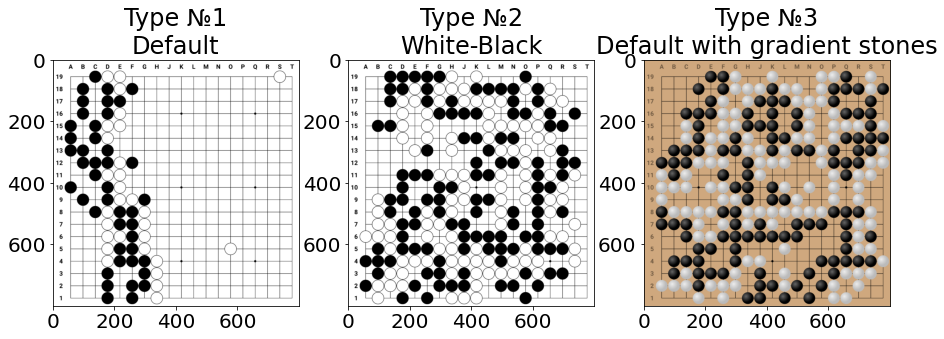

In [11]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(plt.imread(dataset.imgs[0][0]))
ax[0].set_title("Type №1\nDefault")
ax[1].imshow(plt.imread(dataset.imgs[1][0])) 
ax[1].set_title("Type №2\nWhite-Black")
ax[2].imshow(plt.imread(dataset.imgs[3][0]))
ax[2].set_title("Type №3\nDefault with gradient stones");

In [12]:
def show_random_backgrounds(background_dir: str, cols: int, rows: int, figsize: tuple=(14, 14)):
    figure = plt.figure(figsize=figsize)
    cols, rows = cols, rows
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(os.listdir(background_dir)), size=(1,)).item()
        i_random_background = random.randint(0, len(os.listdir(background_dir))-1)
        img = Image.open(os.path.join(background_dir,
                                                   os.listdir(background_dir)[i_random_background]))
        figure.add_subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
    plt.show()
    
def show_random_ds_images(cols: int, rows: int, figsize: tuple=(14, 14)):
    figure = plt.figure(figsize=figsize)
    cols, rows = cols, rows
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(dataset.classes[label])
        plt.imshow(img.permute(1, 2, 0))
        plt.axis("off")
    plt.show()

## Examples of images in the augmented dataset
Randomly selected images from the dataset

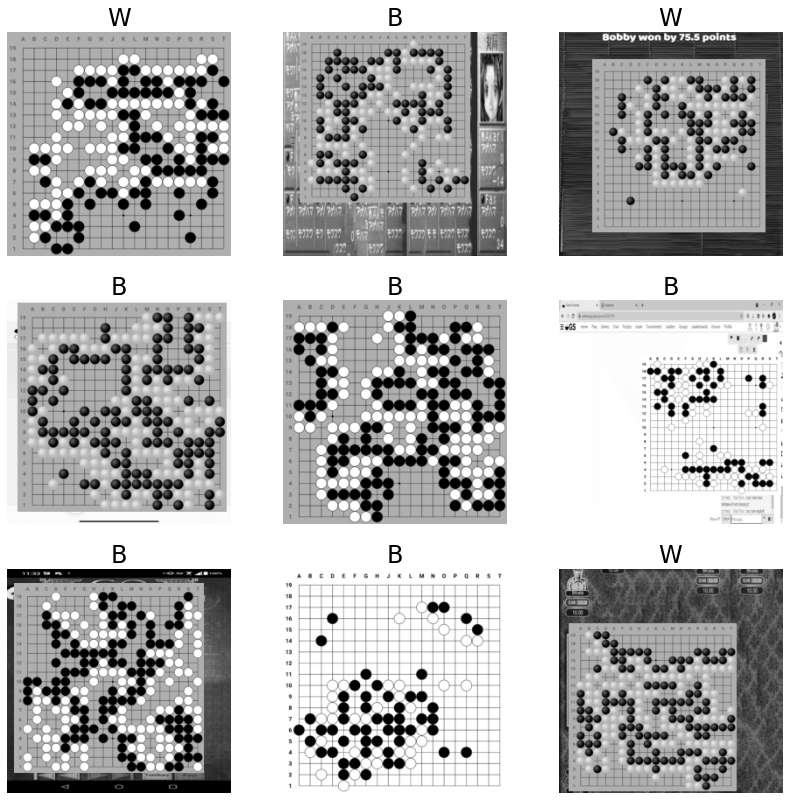

In [13]:
show_random_ds_images(3, 3)

## Model

In [14]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
model.classifier = nn.Linear(1024, 2, bias=True)
weights_url = "https://github.com/roykoand/GoWinnerPrediction/releases/download/version(-1)/DenseNet121_weights.h5"
model.load_state_dict(torch.hub.load_state_dict_from_url(weights_url, progress=False, map_location=torch.device("cpu")))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  
print(f"Availiable device for training: <{device}>")
model = model.to(device)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Downloading: "https://github.com/roykoand/GoWinnerPrediction/releases/download/version(-1)/DenseNet121_weights.h5" to /root/.cache/torch/hub/checkpoints/DenseNet121_weights.h5


Availiable device for training: <cuda:0>


## Training loop

One epoch takes near half of the hour, so 45 * 0.5 = 22.5 hours we need for training our model. The bad news is that Kaggle allows only 9 hours per session, so we need to save weights and retrain our model again and again. For these reasons, below you can see only 2 epochs as an example of the training loop on the already trained weights.

In [88]:
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0003) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
loss = nn.CrossEntropyLoss().cuda() 


train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(1, 3): # EPOCHS + 1
    train_loss = 0
    valid_loss = 0
    train_acc = 0
    valid_acc = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        model.train()
        for (X, y) in tepoch:
            tepoch.set_description(f"Epoch [{epoch}/{EPOCHS}] | LR [{optimizer.param_groups[0]['lr']}] | Train set")
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            y_hat = model(X)
            l = loss(y_hat, y)

            l.backward()
            optimizer.step()

            train_loss += l.item()
            train_acc += torch.sum(y_hat.max(dim=1)[1] == y).item()
            tepoch.set_postfix({"Train Loss": train_loss / len(train_loader), 
                                "Train Accuracy":  100. * train_acc / TRAIN_LENGTH})
            
    train_losses.append(train_loss/len(train_loader))
    train_accuracies.append(100. * train_acc / TRAIN_LENGTH)
        
    model.eval()
    with torch.no_grad():
        with tqdm(valid_loader, unit="batch") as tepoch:

            for (X, y) in tepoch:
                tepoch.set_description(f"Epoch [{epoch}/{EPOCHS}] | Validation set")
                X, y = X.to(device), y.to(device)

                y_hat = model(X)
                l = loss(y_hat, y)

                valid_acc += torch.sum(y_hat.max(dim=1)[1] == y).item()
                valid_loss += l.item()
                tepoch.set_postfix({"Validation Loss": valid_loss / len(valid_loader), 
                                "Validation Accuracy": 100. * valid_acc / VALID_LENGTH})
    valid_losses.append(valid_loss/len(valid_loader))
    valid_accuracies.append(100. * valid_acc / VALID_LENGTH)  
    scheduler.step(valid_loss/len(valid_loader))
    torch.save(model.state_dict(), f"weights-epoch-{epoch}.h5")

Epoch [1/30] | LR [0.0003] | Train set: 100%|██████████| 3000/3000 [24:29<00:00,  2.04batch/s, Train Loss=0.542, Train Accuracy=72.5]  
Epoch [1/30] | Validation set: 100%|██████████| 563/563 [03:51<00:00,  2.43batch/s, Validation Loss=0.526, Validation Accuracy=73.6] 
Epoch [2/30] | LR [0.0003] | Train set: 100%|██████████| 3000/3000 [24:16<00:00,  2.06batch/s, Train Loss=0.544, Train Accuracy=71.8] 
Epoch [2/30] | Validation set: 100%|██████████| 563/563 [03:52<00:00,  2.42batch/s, Validation Loss=0.523, Validation Accuracy=74.4] 


## Epoch/Metric plots

In [85]:
def metric_plot(train_metric: list, valid_metric: list, metric_name: str, epoch=range(1, 46)) -> None:
    plt.figure(figsize=(12, 8))
    plt.grid()
    plt.plot(epoch, train_metric,'-bx', label=f'Train {metric_name}')
    plt.plot(epoch, valid_metric,'-rx', label=f'Valid {metric_name}')
    plt.axvline(x=36)
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.title())
    plt.legend()
    plt.title(f'Model {metric_name}')
    plt.show()

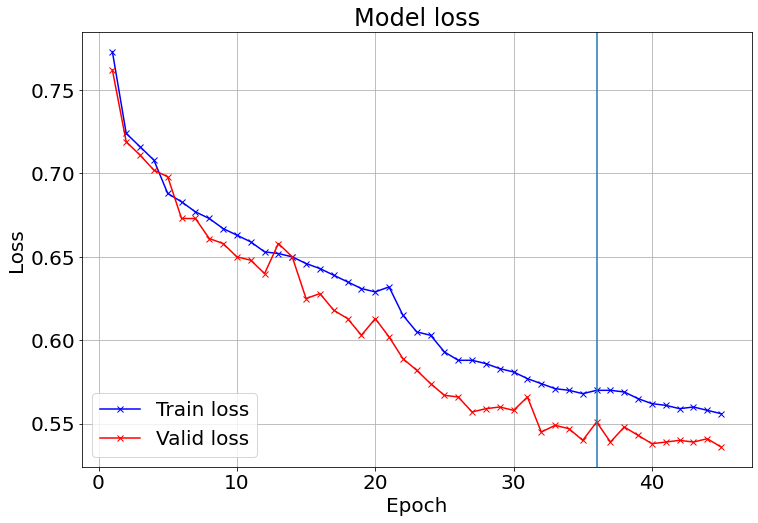

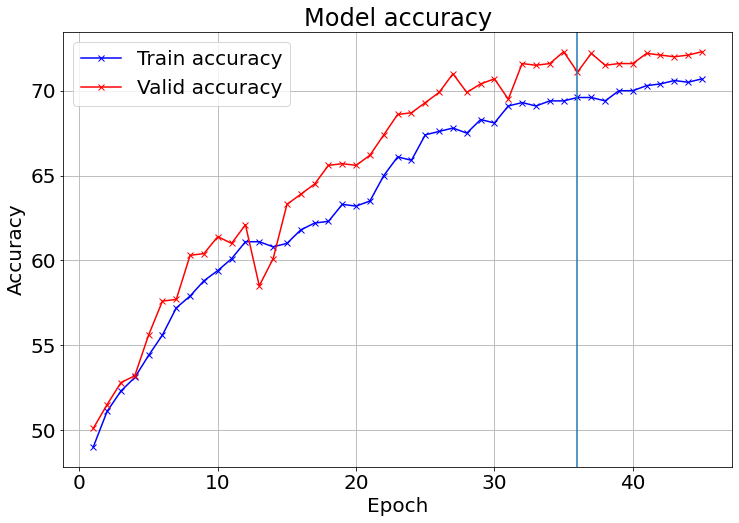

In [86]:
epoch_metric_info = pd.read_csv("epoch-metrics.csv")
metric_plot(epoch_metric_info["Train loss"], epoch_metric_info["Test loss"], "loss")
metric_plot(epoch_metric_info["Train accuracy"], epoch_metric_info["Test accuracy"], "accuracy")

In [89]:
model.eval()
test_acc, test_loss = 0, 0
y_true = []
y_pred = []
with torch.no_grad():
    with tqdm(test_loader, unit="batch") as tepoch:
        for (X, y) in tepoch:
            tepoch.set_description("Test set")
            X, y = X.to(device), y.to(device)

            y_hat = model(X)
            l = loss(y_hat, y)
            y_true.extend(y.tolist())
            y_pred.extend(y_hat.max(dim=1)[1].tolist())

            test_acc += torch.sum(y_hat.max(dim=1)[1] == y).item()
            test_loss += l.item()
            tepoch.set_postfix({"Test Loss": test_loss / len(test_loader), 
                            "Test Accuracy": 100. * test_acc / TEST_LENGTH})

Test set: 100%|██████████| 47/47 [01:16<00:00,  1.63s/batch, Test Loss=0.549, Test Accuracy=72.2]


## Metrics on the test dataset

In [90]:
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, precision_score, recall_score
metrics = [accuracy_score,balanced_accuracy_score, f1_score, precision_score, recall_score]
for metric in metrics:
    print(f"{metric.__name__} = {100. * round(metric(y_true, y_pred), 3)}")

accuracy_score = 72.2
balanced_accuracy_score = 72.2
f1_score = 73.2
precision_score = 73.6
recall_score = 72.8


## Visualize predictions of our model
The title of the image is a real label. If title with red color - our model is wrong on this image, green is right

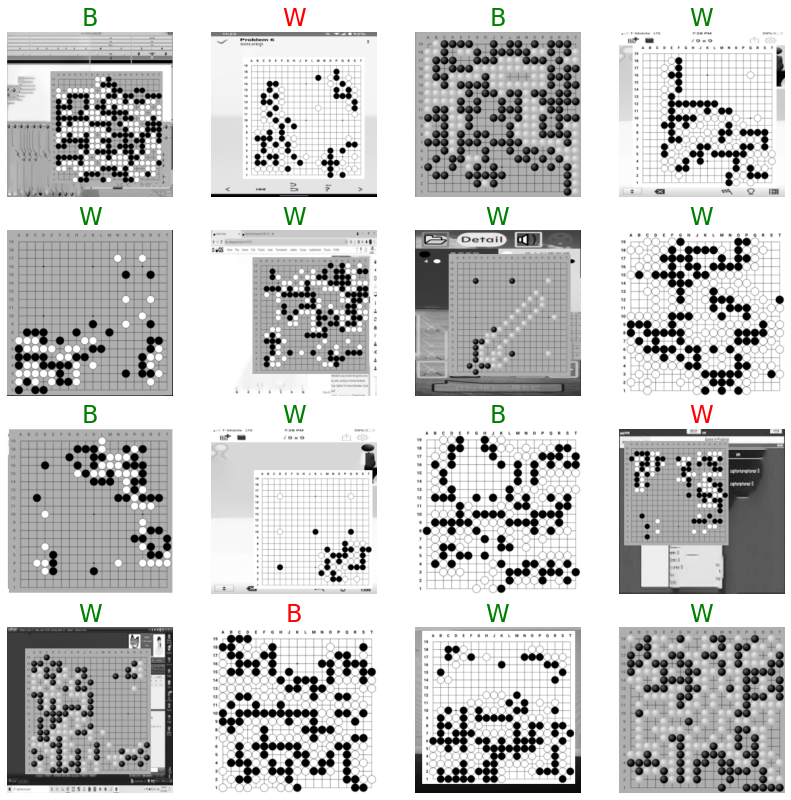

In [35]:
figure = plt.figure(figsize=(14, 14))
cols, rows = 4, 4
images, labels = next(iter(test_loader))
for i in range(1, cols * rows + 1):
    img, label = images[i], labels[i]
    predicted_label = model(img.unsqueeze(0).cuda())
    color = "green"
    if predicted_label.max(dim=1)[1] != label:
        color = "red"
    figure.add_subplot(rows, cols, i)
    plt.title(train_dataset.dataset.classes[label], color=color)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
plt.show()

## Confusion matrix

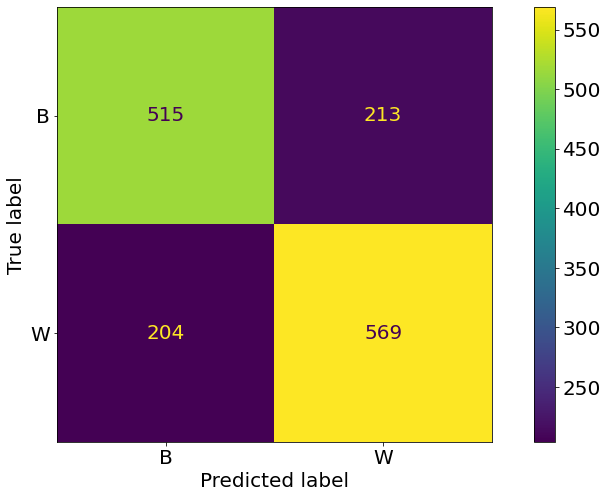

In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_pred, y_true,)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["B", "W"])
disp.plot()
plt.show()